In [1]:
%config Completer.use_jedi = False

In [2]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Graph parameters

We're going to build some Erdos-Renyi (ER) models varying its parameters. When we fix a connection probability we're also fixing its degree. So we'll create some realizations for each combination of n and z.

In [3]:
nodes_array = np.arange(1000, 12000, 2000)#[1000, 2000, 4000, 6000, 8000, 10000]
avg_degree_array = [0, 0.5, 0.9, 1, 2, 3, 4, "2log"] #np.arange(0, 3.2, 0.2)
ensemble_size = 30

In [4]:
len(nodes_array) * len(avg_degree_array ) * ensemble_size

1440

In [5]:
def find_percolation_threshold(n = 1000, threshold = 0.5, step = 0.2):
    graphs_dict = dict()
    avg_degree = 0
    while True:
        nodes = n
        graphs_dict[avg_degree] = dict()

        probability = avg_degree/nodes        
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_dict[avg_degree][probability] = graph
        giant = graph.clusters().giant()
        graphs_dict[avg_degree][probability]["giant"] = giant
        giant_fraction = giant.vcount()/n
        avg_degree += step
        if giant_fraction > threshold:
            return graphs_dict

percolations = find_percolation_threshold()

In [6]:
percolations

{0: {0.0: <igraph.Graph at 0x1a4670e38b0>},
 0.2: {0.0002: <igraph.Graph at 0x1a4670e3a90>},
 0.4: {0.0004: <igraph.Graph at 0x1a4670e3c70>},
 0.6000000000000001: {0.0006000000000000001: <igraph.Graph at 0x1a4671ee040>},
 0.8: {0.0008: <igraph.Graph at 0x1a4671ee220>},
 1.0: {0.001: <igraph.Graph at 0x1a4671ee400>},
 1.2: {0.0012: <igraph.Graph at 0x1a4671ee5e0>},
 1.4: {0.0014: <igraph.Graph at 0x1a4671ee7c0>}}

## Graph building

In [7]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, avg_degree_array])

graphs_dict = dict()
# Print the obtained permutations
for network_property in list(perm):
    
    graphs_list = list()
    nodes = int(network_property[0])
    
    if network_property[1] in ["log", "2log"]:
        degree = 2*np.round(np.log(nodes), 2)
        key = str(nodes) + '_nodes__' + network_property[1] + "_degree"
    else:
        degree = network_property[1]
        key = str(nodes) + '_nodes__' + str(degree) + "_degree"
    probability = degree/nodes
    
    # Create a few realizations
    for i in range(ensemble_size):
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_list.append(graph)
    
    graphs_dict[key] = dict()
    graphs_dict[key]['graphs'] = graphs_list
    graphs_dict[key]["nodes"] = nodes
    graphs_dict[key]["degree"] = network_property[1]
    graphs_dict[key]["probability"] = probability    

Wall time: 6.75 s


## Calculate statistics and metrics

In [8]:
%%time
# Calculate some metrics for each graph realization

avg_degrees = list()
nodes_number = list()
connection_probabilities = list()
diameters = list()
sample_realizations = list()
edges_number = list()
giant_size = list()
expected_avg_degree = list()
giant_diameter = list()

for params in graphs_dict.keys():
    i = 1
    for graph in graphs_dict[params]["graphs"]:
        sample_realizations.append(i)
        i += 1
        
        nodes_degree = graph.degree()
        edges_number.append(len(graph.get_edgelist()))
        diameters.append(len(graph.get_diameter()))
        nodes_number.append(graphs_dict[params]["nodes"])
        connection_probabilities.append(graphs_dict[params]["probability"])
        expected_avg_degree.append(graphs_dict[params]["degree"])
        avg_degrees.append(np.mean(nodes_degree))
        giant = graph.clusters().giant()
        giant_size.append(giant.vcount())
        giant_diameter.append(giant.diameter())
        

Wall time: 47min 54s


In [9]:
# sample_graph = graphs_dict["100_nodes__7_degree"]["graphs"][0]
# sample_graph.vertex_connectivity()

In [10]:
ensemble_analysis = pd.DataFrame()
ensemble_analysis["nodes_number"] = nodes_number
ensemble_analysis["edges_number"] = edges_number

ensemble_analysis["avg_degree"] = avg_degrees
ensemble_analysis["expected_avg_degree"] = expected_avg_degree
# ensemble_analysis["sample_try"] = sample_realizations

ensemble_analysis["q"] = connection_probabilities
# ensemble_analysis["expected_edges_number"] = (ensemble_analysis["nodes_number"] * (ensemble_analysis["nodes_number"] - 1))*ensemble_analysis["connection_probabilities"]/2

ensemble_analysis["log(n)"] = np.log(ensemble_analysis["nodes_number"])
ensemble_analysis["1/n"] = 1/ensemble_analysis["nodes_number"]
ensemble_analysis["diameter"] = diameters
ensemble_analysis["giant_size"] = giant_size
ensemble_analysis["giant_fraction"] = ensemble_analysis["giant_size"]/ensemble_analysis["nodes_number"]
ensemble_analysis["giant_diameter"] = giant_diameter

ensemble_analysis.head()

,nodes_number,edges_number,avg_degree,expected_avg_degree,q,log(n),1/n,diameter,giant_size,giant_fraction,giant_diameter
0,1000,0,0.0,0,0.0,6.907755,0.001,1,1,0.001,0
1,1000,0,0.0,0,0.0,6.907755,0.001,1,1,0.001,0
2,1000,0,0.0,0,0.0,6.907755,0.001,1,1,0.001,0
3,1000,0,0.0,0,0.0,6.907755,0.001,1,1,0.001,0
4,1000,0,0.0,0,0.0,6.907755,0.001,1,1,0.001,0


In [11]:
df_plot = ensemble_analysis.pivot_table(index = ["nodes_number", "expected_avg_degree"],
                                         values = ['avg_degree', "edges_number", "diameter", "giant_diameter", "giant_fraction", "q"],
                                         aggfunc = ["mean"])
df_plot

mean                            \
                                 avg_degree   diameter   edges_number   
nodes_number expected_avg_degree                                        
1000         0                     0.000000   1.000000       0.000000   
             0.5                   0.494000   8.466667     247.000000   
             0.9                   0.888600  17.566667     444.300000   
             1                     0.994600  24.566667     497.300000   
             2                     1.983000  23.233333     991.500000   
             3                     3.018733  15.233333    1509.366667   
             4                     3.982200  11.800000    1991.100000   
             2log                 13.809067   5.600000    6904.533333   
3000         0                     0.000000   1.000000       0.000000   
             0.5                   0.497000   9.500000     745.500000   
             0.9                   0.907556  28.700000    1361.333333   
             1                     1.005644  40.300000    1508.466667   
             2                     1.996467  27.533333    2994.700000   
             3                     2.990067  17.500000    4485.100000   
             4                     3.996244  13.600000    5994.366667   
             2log                 16.045600   6.000000   24068.400000   
5000         0                     0.000000   1.000000       0.000000   
             0.5                   0.499440  10.166667    1248.600000   
             0.9                   0.893893  32.566667    2234.733333   
             1                     1.008680  49.233333    2521.700000   
             2                     1.989653  29.366667    4974.133333   
             3                     2.997693  18.300000    7494.233333   
             4                     4.004840  14.366667   10012.100000   
             2log                 17.053453   6.000000   42633.633333   
7000         0                     0.000000   1.000000       0.000000   
             0.5                   0.495933  10.233333    1735.766667   
             0.9                   0.904105  32.966667    3164.366667   
             1                     1.000667  50.200000    3502.333333   
             2                     1.997467  31.433333    6991.133333   
             3                     2.990581  19.166667   10467.033333   
             4                     4.007629  14.733333   14026.700000   
             2log                 17.698600   6.000000   61945.100000   
9000         0                     0.000000   1.000000       0.000000   
             0.5                   0.500185  11.000000    2250.833333   
             0.9                   0.897422  34.633333    4038.400000   
             1                     0.999941  56.733333    4499.733333   
             2                     2.005585  31.733333    9025.133333   
             3                     2.993815  19.566667   13472.166667   
             4                     3.992326  15.233333   17965.466667   
             2log                 18.205444   6.000000   81924.500000   
11000        0                     0.000000   1.000000       0.000000   
             0.5                   0.499745  11.333333    2748.600000   
             0.9                   0.904558  38.933333    4975.066667   
             1                     0.996127  58.000000    5478.700000   
             2                     1.999667  31.566667   10998.166667   
             3                     3.000467  20.233333   16502.566667   
             4                     4.001848  15.433333   22010.166667   
             2log                 18.615115   6.000000  102383.133333   

                                                                          
                                 giant_diameter giant_fraction         q  
nodes_number expected_avg_degree                                          
1000         0                         0.000000       0.001000  0.000000  
             0.

In [12]:
ensemble_analysis.pivot_table(index = ["expected_avg_degree", "nodes_number"],
                                         values = ['avg_degree', "log(n)", "diameter", "giant_diameter", "giant_fraction", "q"],
                                         aggfunc = ["mean"])

mean                            \
                                 avg_degree   diameter giant_diameter   
expected_avg_degree nodes_number                                        
0                   1000           0.000000   1.000000       0.000000   
                    3000           0.000000   1.000000       0.000000   
                    5000           0.000000   1.000000       0.000000   
                    7000           0.000000   1.000000       0.000000   
                    9000           0.000000   1.000000       0.000000   
                    11000          0.000000   1.000000       0.000000   
0.5                 1000           0.494000   8.466667       7.300000   
                    3000           0.497000   9.500000       8.100000   
                    5000           0.499440  10.166667       8.766667   
                    7000           0.495933  10.233333       8.466667   
                    9000           0.500185  11.000000       9.200000   
                    11000          0.499745  11.333333       9.733333   
0.9                 1000           0.888600  17.566667      16.333333   
                    3000           0.907556  28.700000      27.066667   
                    5000           0.893893  32.566667      30.600000   
                    7000           0.904105  32.966667      30.733333   
                    9000           0.897422  34.633333      32.600000   
                    11000          0.904558  38.933333      36.033333   
1                   1000           0.994600  24.566667      23.233333   
                    3000           1.005644  40.300000      39.266667   
                    5000           1.008680  49.233333      47.133333   
                    7000           1.000667  50.200000      48.500000   
                    9000           0.999941  56.733333      54.600000   
                    11000          0.996127  58.000000      56.133333   
2                   1000           1.983000  23.233333      22.233333   
                    3000           1.996467  27.533333      26.533333   
                    5000           1.989653  29.366667      28.366667   
                    7000           1.997467  31.433333      30.433333   
                    9000           2.005585  31.733333      30.733333   
                    11000          1.999667  31.566667      30.566667   
3                   1000           3.018733  15.233333      14.233333   
                    3000           2.990067  17.500000      16.500000   
                    5000           2.997693  18.300000      17.300000   
                    7000           2.990581  19.166667      18.166667   
                    9000           2.993815  19.566667      18.566667   
                    11000          3.000467  20.233333      19.233333   
4                   1000           3.982200  11.800000      10.800000   
                    3000           3.996244  13.600000      12.600000   
                    5000           4.004840  14.366667      13.366667   
                    7000           4.007629  14.733333      13.733333   
                    9000           3.992326  15.233333      14.233333   
                    11000          4.001848  15.433333      14.433333   
2log                1000          13.809067   5.600000       4.600000   
                    3000          16.045600   6.000000       5.000000   
                    5000          17.053453   6.000000       5.000000   
                    7000          17.698600   6.000000       5.000000   
                    9000          18.205444   6.000000       5.000000   
                    11000         18.615115   6.000000       5.000000   

                                                                     
                                 giant_fraction    log(n)         q  
expected_avg_degree nodes_number                                     
0                   1000               0.001000  6.907755  0.000000  
                    3000           

## Can you observe the connectivity threshold?

We saw that if $\frac{q(n)}{q^P(n)} \rightarrow \infty$ P is valid with high probability (whp). Also if we observe that $\frac{q(n)}{q^P(n)} \rightarrow 0$ P is not valid w.h.p., where P is a network property. To have connectivity we should observe

$$\frac{z}{log(n)} \rightarrow \infty$$

So, in order to have connectivity, $z$ should grow at least $log(n)$. If the network is connected, the diameter of the giant component should only increase or remains constant as the number of nodes increases. In the graph we can observe that for the case where the expected average degree is equal to $log(n)$ the giant component diameter is constant. This is not observed for other cases where $\bar{z} = \{0.9, 1.0 \}$. 

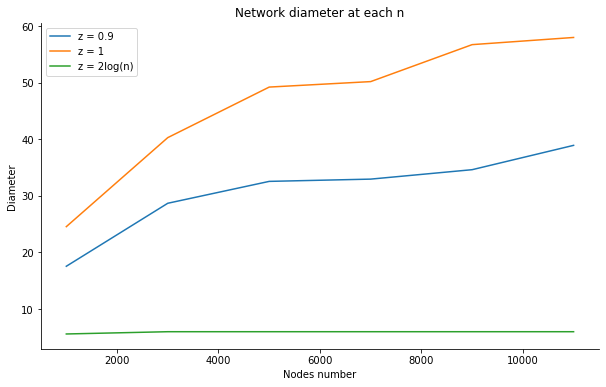

In [13]:
fig, ax = plt.subplots(figsize = (10, 6))

df = df_plot.reset_index()

sns.lineplot(data = df[df["expected_avg_degree"].isin([0.9, 1, "2log"])],
             x = ("nodes_number"),
             y = ("mean", 'diameter'),
             hue = ("expected_avg_degree"),
#              palette = sns.color_palette("vlag", as_cmap=True),
             ax = ax)
ax.set_xlabel('Nodes number')
ax.set_ylabel("Diameter")
ax.set_title("Network diameter at each n")
ax.legend(["z = 0.9", "z = 1", "z = 2log(n)"])
sns.despine()

## Extract the giant components and characterize them

As Erdos and Renyi proved w.h.p, that for large n
- If $q > \frac{1}{n}$ there is one giant component
- If $q < \frac{1}{n}$ there are few small components

Also, we need to define what a giant component is. It should be defined in terms of its size relating to tha entire graph size. 

As defined by 
>*"Loosely speaking, a giant component is a connected component whose relative size (compared to the entire network) does not diminish as the size of the network grows to infinity. As the network grows, the giant component grows with it such that its relative size tends to a non-zero constant."*

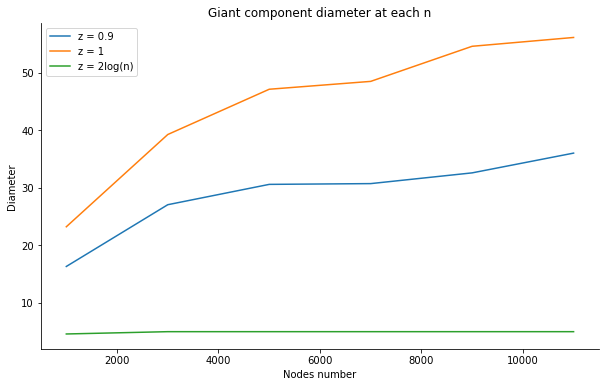

In [14]:
fig, ax = plt.subplots(figsize = (10, 6))

df = df_plot.reset_index()

sns.lineplot(data = df[df["expected_avg_degree"].isin([0.9, 1, "2log"])],
             x = ("nodes_number"),
             y = ("mean", 'giant_diameter'),
             hue = ("expected_avg_degree"),
#              palette = sns.color_palette("vlag", as_cmap=True),
             ax = ax)
ax.set_xlabel('Nodes number')
ax.set_ylabel("Diameter")
ax.set_title("Giant component diameter at each n")
ax.legend(["z = 0.9", "z = 1", "z = 2log(n)"])

sns.despine()

As we can see in the chart above, the size of the giant component does not decrease as the network increase. The chart below displays the proportion of nodes that are in the giant component. As we can see, this proportion does not decrease as the number of nodes increases.

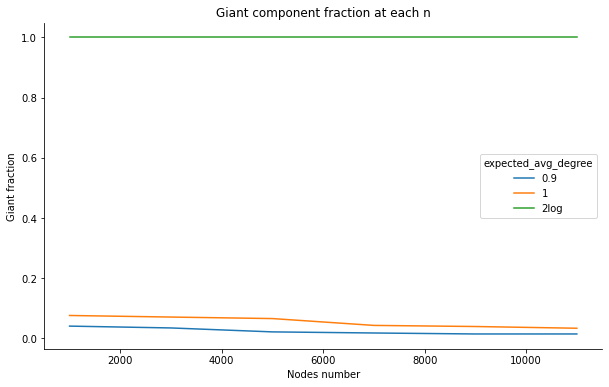

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))

df = df_plot.reset_index()

sns.lineplot(data = df[df["expected_avg_degree"].isin([0.9, 1, "2log"])],
             x = ("nodes_number"),
             y = ("mean", 'giant_fraction'),
             hue = ("expected_avg_degree"),
#              palette = sns.color_palette("vlag", as_cmap=True),
             ax = ax)
ax.set_xlabel('Nodes number')
ax.set_ylabel("Giant fraction")
ax.set_title("Giant component fraction at each n")
sns.despine()

In [16]:
def in_giant(G):
    cl = G.components()
    cl_sizes = cl.sizes()
    giant_component_index = cl_sizes.index(max(cl_sizes))
    return [x == giant_component_index for x in cl.membership]

# nodes_in_giant = in_giant(sample_graph)

## Does the network diameter follows the logarithimic variation?

The plot below shows the diameter for each value of n and a fixed value of $z$. As z increases the network diameter fits better the $log(n)$ line. So we can observe that the diameter follows the logarithimic variation.

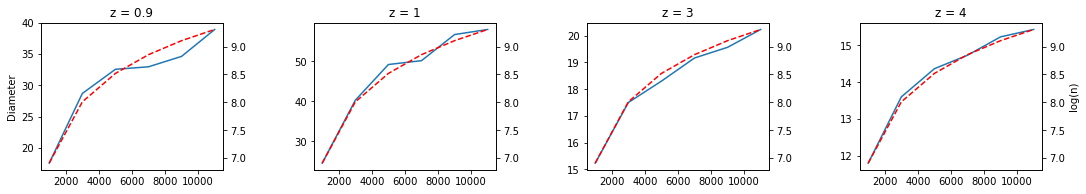

In [45]:
z_values = [0.9, 1, 3, 4]

fig, ax = plt.subplots(nrows = 1, 
                       ncols = len(z_values), figsize = (16, 4),
                       sharey = False)

fig.tight_layout(pad=6)

for i in range(len(z_values)):
    # Filter the dataset
    data = df[df["expected_avg_degree"].isin([z_values[i]])]
    ax[i].plot(data[ ("nodes_number")], data[("mean", "diameter")], )
    
    # plot logarithm line to comparisons
    ax2 = ax[i].twinx()
    ax2.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
             np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
             color = "red", 
             linestyle = "dashed",)
    
    # Titles and legends
    ax[i].set_title(f"z = {z_values[i]}")
    
_ = ax[0].set_ylabel("Diameter")
_ = ax2.set_ylabel("log(n)")


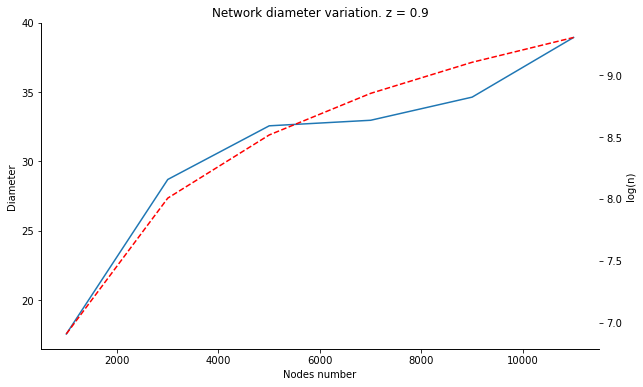

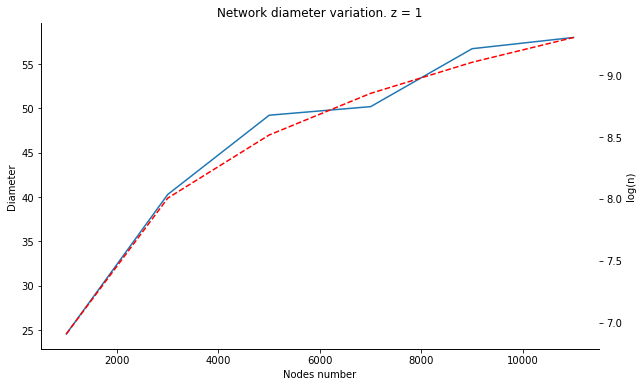

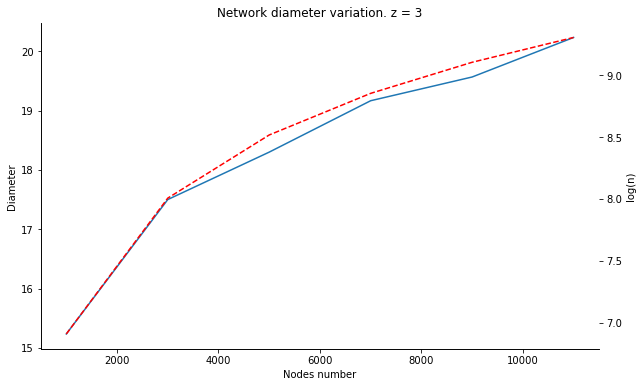

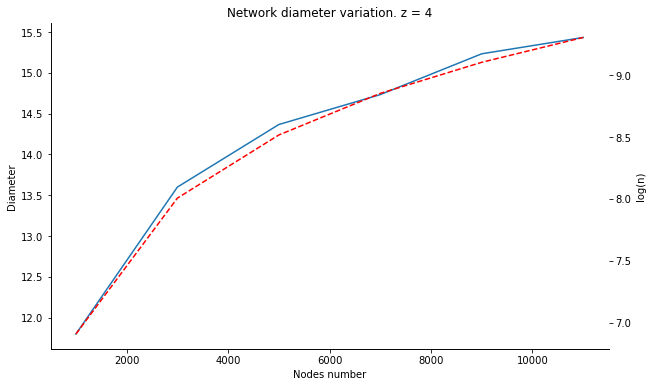

In [17]:
# fig, ax = plt.subplots(figsize = (10, 6))

df = df_plot.reset_index()

for z in [0.9, 1, 3, 4]:
    fig, ax = plt.subplots(figsize = (10, 6))
    sns.lineplot(data = df[df["expected_avg_degree"].isin([z])],
                 x = ("nodes_number"),
                 y = ("mean", "diameter"),
    #              hue = "expected_avg_degree",
                 palette = "coolwarm",
                 ax = ax)

    ax2 = ax.twinx()
    plt.plot(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")],
             np.log(df[df["expected_avg_degree"].isin(["2log"])][("nodes_number")]),
             color = "red", 
             linestyle = "dashed",)


    ax.set_xlabel('Nodes number')
    ax.set_ylabel("Diameter")
#     ax.legend([f"z = {z}"])
    # ax2.legend(["log(n)"], )
    ax2.set_ylabel("log(n)")
    ax.set_title(f"Network diameter variation. z = {z}")
    sns.despine()